# Homework 3

DUE Nov 15th at 11:59 PM

## Problem 1

In this problem, you will implement a simple feed-forward neural network using PyTorch, a straight-forward and simple-to-pickup framework for quickly prototyping deep learning model. 

PyTorch provides 2 powerful things. First, a nice data structure called Tensor (basically a matrix, similar to Numpy ndarray). Tensor is optimized for matrix calculation and can be loaded to a GPU. Tensor is also implemented so that it's easy to calculate and pass back chains of gradients, which is extremely useful for backpropagation on neural network. Second, a nice inner mechanism called Autograd that nicely maps variables involved a chain of calculations and efficiently calculates their gradients via the chain rule when needed. Read more here: https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95  

You will define a neural network class in PyTorch and use the network to learn a classification task on the famous KDD CUP 99 dataset. You can refer to Problem 2 to see how a network class can be defined, how to use a PyTorch's DataLoader, and how a training loop may looks like.

There are many greate tutorial on PyTorch out there. For example, this video on Youtube explains how to build a simple network in PyTorch quite clearly: https://www.youtube.com/watch?v=oPhxf2fXHkQ

### Part a
Firstly, load and inspect the "**KDD CUP 99**" dataset.

In [2]:
from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
import torch

X, y = fetch_kddcup99(return_X_y=True, percent10=True)

# enc = OrdinalEncoder()
# enc.fit(X[:,1:4])
# X[:,1:4] = enc.transform(X[:,1:4])

# lab = LabelEncoder()
# lab.fit(y)
# y = lab.transform(y)

In [3]:
X

array([[0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
       [0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
       [0, b'tcp', b'http', ..., 0.0, 0.0, 0.0],
       ...,
       [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0],
       [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0],
       [0, b'tcp', b'http', ..., 0.01, 0.0, 0.0]], dtype=object)

Split them into a train set (70%), a validation set (10%), and a test set (20%). Then, create a PyTorch's DataLoader for the train set, a DataLoader for the validation set, and a DataLoader for the test set.

You can read about PyTorch's DataLoader from:

*   https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
*   https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader



In [82]:
class Dataset(torch.utils.data.Dataset):
    # Characterizes a dataset for PyTorch'
    def __init__(self, X, y):
        #'Initialization'
        self.labels = torch.tensor(y)
        self.features = torch.tensor(X)

    def __len__(self):
        #'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        #'Generates one sample of data'
        # Select sample
        return self.features[index], self.labels[index]

In [83]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np

# Define test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2, random_state=123,
                                                    shuffle=True)

# Split part of train into validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size = 0.125, random_state=123,
                                                 shuffle=True)

X_train = np.array(X_train, dtype=float)
X_val = np.array(X_val, dtype=float)
X_test = np.array(X_test, dtype=float)

In [84]:
# Create Datasets to input to loaders
train_dataset = Dataset(X_train, y_train)
val_dataset = Dataset(X_val, y_val)
test_dataset = Dataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True, num_workers=0)

### Part b 
Create a Python class for our neural network model. The network should have 1 input layer, 1 hidden layer, and 1 output layer. You are free to choose the size of the hidden layer (it may affect the performance). Use ReLU as the activation function (torch.relu).

In [85]:
input_size = 41
hidden_size = 64
num_classes = 23

In [86]:
import torch.nn as nn

# Any Pytorch's network class is an extension of the torch.nn.Module parent class.
# To define a network class, you need to define at least 2 methods: 
# an __init__() method (constructor) and a forward() method
class SimpleNetwork(torch.nn.Module):
    # Create the network class by filling in this block of code

    # Create the constructor. Add any additional arguments as you wish
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes) 
    
    # Define the feed forward function.
    # x is the input example/examples.
    # Add any additional arguments as you wish.
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

### Part c 
Train the network using the training dataset. Use the SGD optimizer and CrossEntropyLoss. After each epoch, record the current loss and the current training accuracy. The current training accuracy is obtained by evaluating the model on the train dataset. Use the DataLoaders defined in part a to efficiently pass training and testing data.

You can learn about the available optimizers at:
https://pytorch.org/docs/stable/optim.html

You can learn about the available loss functions at:
https://pytorch.org/docs/stable/nn.html#loss-functions

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNetwork(input_size, hidden_size, num_classes).to(device)

LEARNING_RATE = 0.01
EPOCHS = 100

# number of parameters in model is equal to number of hidden channels
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)  

training_acc = []
validation_acc = []
losses = []
n_total_steps = len(train_loader)

for epoch in range(EPOCHS):
    for i, (features, labels) in enumerate(train_loader):
        
        features = features.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(features.float())  
        loss = criterion(outputs, labels)
        
        # Reset the gradients, backpropogate, optimize
        optimizer.zero_grad()
        loss.backward()  # backwards pass
        optimizer.step()  # gradient descent
        
        if i == 0:
            losses.append(loss.item())
            print (f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')
            # Compute train accuracy
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                for features, labels in train_loader:
                    features = features.to(device)
                    labels = labels.to(device)
                    outputs = model(features.float())
                    _, predicted = torch.max(outputs.data, 1)
                    n_samples += labels.size(0)
                    n_correct += (predicted == labels).sum().item()

            train_acc = n_correct / n_samples

            training_acc.append(train_acc)
            print(f'Accuracy of the network on training set: {100*train_acc:.4f} %')
            
            with torch.no_grad():
                n_correct = 0
                n_samples = 0
                for features, labels in val_loader:
                    features = features.to(device)
                    labels = labels.to(device)
                    outputs = model(features.float())
                    _, predicted = torch.max(outputs.data, 1)
                    n_samples += labels.size(0)
                    n_correct += (predicted == labels).sum().item()
            
            val_acc = n_correct / n_samples
            validation_acc.append(val_acc)
            print(f'Accuracy of the network on validation set: {100*val_acc:.4} %')



Epoch [1/100], Loss: 112.0067
Accuracy of the network on training set: 64.9254 %
Accuracy of the network on validation set: 65.06 %
Epoch [2/100], Loss: 0.5963
Accuracy of the network on training set: 80.2319 %
Accuracy of the network on validation set: 79.94 %
Epoch [3/100], Loss: 0.4339
Accuracy of the network on training set: 81.0783 %
Accuracy of the network on validation set: 80.8 %
Epoch [4/100], Loss: 0.6055
Accuracy of the network on training set: 80.1246 %
Accuracy of the network on validation set: 79.87 %
Epoch [5/100], Loss: 0.4929
Accuracy of the network on training set: 80.6246 %
Accuracy of the network on validation set: 80.33 %
Epoch [6/100], Loss: 0.4164
Accuracy of the network on training set: 80.9198 %
Accuracy of the network on validation set: 80.66 %
Epoch [7/100], Loss: 0.4200
Accuracy of the network on training set: 80.9103 %
Accuracy of the network on validation set: 80.62 %
Epoch [8/100], Loss: 0.3959
Accuracy of the network on training set: 80.8518 %
Accuracy o

Epoch [64/100], Loss: 0.4535
Accuracy of the network on training set: 80.4875 %
Accuracy of the network on validation set: 80.25 %
Epoch [65/100], Loss: 0.5326
Accuracy of the network on training set: 82.0201 %
Accuracy of the network on validation set: 81.73 %
Epoch [66/100], Loss: 0.4580
Accuracy of the network on training set: 80.4936 %
Accuracy of the network on validation set: 80.27 %
Epoch [67/100], Loss: 0.6374
Accuracy of the network on training set: 80.3845 %
Accuracy of the network on validation set: 80.11 %
Epoch [68/100], Loss: 0.3933
Accuracy of the network on training set: 81.2176 %
Accuracy of the network on validation set: 80.94 %
Epoch [69/100], Loss: 0.5192
Accuracy of the network on training set: 81.6228 %
Accuracy of the network on validation set: 81.34 %
Epoch [70/100], Loss: 0.5353
Accuracy of the network on training set: 81.6265 %
Accuracy of the network on validation set: 81.31 %
Epoch [71/100], Loss: 0.4523
Accuracy of the network on training set: 81.5832 %
Acc

Plot how the loss and the training accuracy and the validation accuracy change over the epochs. Is there a point where overfitting occurs? If you cannot spot one, answer no. 

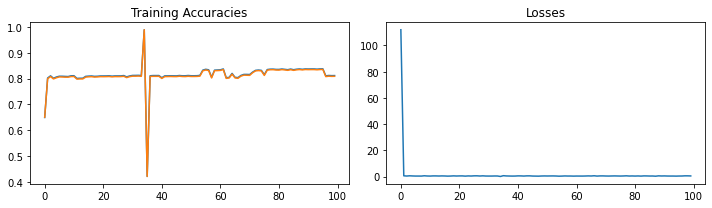

In [88]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
ax[0].plot(range(EPOCHS), training_acc, label = "Train Accuracy")
ax[0].plot(range(EPOCHS), validation_acc, label = "Validation Accuracy")
ax[0].set_title('Training Accuracies')
ax[1].plot(range(EPOCHS), losses)
ax[1].set_title('Losses')
fig.tight_layout()

plt.show()

It looks like there is point where overfitting occurs at roughly the 35th point, and as a result, the model's accuracy suffers immediately after. However, it is able to still converge back to a fairly consistent result

### Part d 
Evaluate the model on the test dataset. Print out the accuracy. Does this accuracy agrees with the training accuracy showed on the plot?

In [89]:
def test(model, criterion, test_loader):
    # Turn the model to testing mode (gradients will not be calculated)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features.float())
            test_loss += criterion(outputs, labels).item()  # sum up batch loss
            pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
            
    print(f'Accuracy of the network on test set: {100 * correct / len(test_loader.dataset)}')
    
criterion = nn.CrossEntropyLoss()
test(model, criterion, test_loader)


Accuracy of the network on test set: 81.0414452709883


Based on our results from the training data, the accuarcy here lines up.

## Problem 2

In this problem, we will investigate the effects of various common hyperparameters on the performance of a neural network. In the following cell, you can find a network class already defined for you. You can initiate network instances with different hyperparameters by changing the constructor's arguments.

You are graded based on how you implement and execute the experiments. Since there is some randomness in initiating and training a neural network, there is no guarantee that you will get an expected result for an experiment or that your results should be similar to those of your peers. The expected outcome is that you execute the experiments correctly and the conclusion you get are consistent with your results. For each experiments, try to run the code multiple times and record the average results like what we did in Homework 2 (it will take some time to run, as expected when training any neural network).

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class mnist_network(torch.nn.Module):
    
    def __init__(self, num_hidden_layers=1, layer_size = 100, activation=None):
        super(mnist_network, self).__init__()
        # layers of the network
        self.num_hidden_layers = num_hidden_layers
        self.layer_size = layer_size
        self.activation = activation

        if(self.activation == 'relu'):
            self.activation = F.relu
        elif(self.activation == 'tanh'):
            self.activation = torch.tanh

        self.layers = nn.ModuleList([nn.Linear(784,self.layer_size)])
        for i in range(1, self.num_hidden_layers):
            self.layers.append(nn.Linear(self.layer_size,self.layer_size))
        self.layers.append(nn.Linear(self.layer_size,10))

    def forward(self, x):
        # converting each image into a vector
        batch_size = x.shape[0]
        x = x.reshape(batch_size,-1)
        # rest of the forward pass 
        for i in range(self.num_hidden_layers+1):
            x = self.layers[i](x)
            if(self.activation is not None):
                x = self.activation(x)
        return x

Run the following code to load the MNIST dataset. For the sake of simplicity, we do not have a validation set in this problem.

In [22]:
import torch
from torchvision import datasets, transforms

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)

# DataLoader is a nice tool provided by PyTorch for passing training or testing examples
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

Here is an example of training and testing a model:

In [40]:
import torch.nn as nn
import torch.optim as optim
import itertools

def train(model, criterion, train_loader, optimizer, epoch):
    # Turn the model to training mode (gradients will be calculated)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We have to call zero_grad() on the optimizer to remove gradients from the previous data pass.
        # Otherwise, the gradients will be accumulated throughout many passes.
        optimizer.zero_grad()
        # Pass in the data and obtain the output.
        # When you pass the data directly by calling model(data), the model will internally pass the data through the forward() function.
        output = model(data)
        # Compare the output and the ground truth and calculate the loss.
        loss = criterion(output, target)
        # From the calculated loss, call backward() to calculate the gradients for all the paramters in the network.
        loss.backward()
        # Update the parameters according to the gradients. 
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, criterion, test_loader):
    # Turn the model to testing mode (gradients will not be calculated)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return accuracy

# Number of training epochs
epochs = 5
# Learning rate
lr = 0.01

# Create the model
model = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')

# Define the training and testing loss
train_criterion = nn.CrossEntropyLoss()
test_criterion = nn.CrossEntropyLoss(reduction='sum')

# Define the optimizer
# We have to specify the learning rate and the parameters that the optimizer should update during training.
# In this case, we specify that the optimizer should update all the parameters from our model.
optimizer = optim.SGD(model.parameters(),lr=lr)

for epoch in range(1, epochs + 1):
    # Training
    train(model, train_criterion, train_loader, optimizer, epoch)
    # Testing
    test(model, test_criterion, test_loader)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312148
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.661013
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.153798
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.890773
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.601178
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.625142
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.615317
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.800792
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.657874
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.708585

Test set: Average loss: 0.5738, Accuracy: 8494/10000 (85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.560406
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.346600
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.263422
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.404671
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.278740
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.366671
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.221094
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.428373
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.348852
T

## Part a

First, we will investigate the effect of varying the size of the hidden layer. Create 3 one-hidden-layer networks with the sizes of the hidden layers being 5, 20, 50, respectively. We will call these the 5-network, the 20-network, and the 50-network. All networks should use ReLU activation.

Train the 5-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [41]:
# Number of training epochs
epochs = 10
# Learning rate
lr = 0.001

# Create the model
model_5 = mnist_network(num_hidden_layers=1,layer_size=5,activation='relu')

# Define the training and testing loss
train_criterion = nn.CrossEntropyLoss()
test_criterion = nn.CrossEntropyLoss(reduction='sum')

# Define the optimizer
# We have to specify the learning rate and the parameters that the optimizer should update during training.
# In this case, we specify that the optimizer should update all the parameters from our model.
optimizer = optim.SGD(model_5.parameters(),lr=lr)

train_5 = []

for epoch in range(1, epochs + 1):
        # Training
        train(model_5, train_criterion, train_loader, optimizer, epoch)
        # Testing
        train_5.append(test(model_5, test_criterion, train_loader))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321440
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.208445
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.209888
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.199331
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.964409
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.998427
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.061806
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.065061
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.017438
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.168442

Test set: Average loss: 1.9569, Accuracy: 22724/60000 (38%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.875798
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.841540
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.966337
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.961886
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.657763
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.735698
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.806366
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.913833
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.841156


Test the trained 5-network on the test data. Print out the accuracy.

In [42]:
test(model_5, test_criterion, test_loader)


Test set: Average loss: 1.3408, Accuracy: 5252/10000 (53%)



52.52

Train the 20-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [43]:
model_20 = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')
optimizer = optim.SGD(model_20.parameters(),lr=lr)

train_20 = []

for epoch in range(1, epochs + 1):
        # Training
        train(model_20, train_criterion, train_loader, optimizer, epoch)
        # Testing
        train_20.append(test(model_20, test_criterion, train_loader))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317551
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.228011
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.240905
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.129658
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.076414
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.021779
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.940824
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.206467
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.881568
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.686215

Test set: Average loss: 1.7618, Accuracy: 29224/60000 (49%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.756814
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.633259
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.617725
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.500919
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.376581
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.399405
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.417740
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.695238
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.391897


Test the trained 20-network on the test data. Print out the accuracy.

In [44]:
test(model_20, test_criterion, test_loader)


Test set: Average loss: 0.7815, Accuracy: 7730/10000 (77%)



77.3

Train the 50-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [45]:
model_50 = mnist_network(num_hidden_layers=1,layer_size=50,activation='relu')
optimizer = optim.SGD(model_50.parameters(),lr=lr)

train_50 = []

for epoch in range(1, epochs + 1):
        # Training
        train(model_50, train_criterion, train_loader, optimizer, epoch)
        # Testing
        train_50.append(test(model_50, test_criterion, train_loader))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298186
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.266451
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.189259
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.049706
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.027826
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.910260
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.848434
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.915681
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.741885
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.581292

Test set: Average loss: 1.5920, Accuracy: 34350/60000 (57%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.628133
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.541206
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.418858
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.353191
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.233823
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.278089
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.314813
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.413110
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.310634


Test the trained 50-network on the test data. Print out the accuracy.

In [46]:
test(model_50, test_criterion, test_loader)


Test set: Average loss: 0.7651, Accuracy: 7840/10000 (78%)



78.4

Plot the training accuracies over the epochs of the networks on the same figure (there should 3 line plots/scatter plots). 

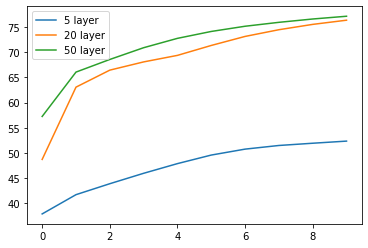

In [47]:
plt.plot(train_5, label = '5 layer')
plt.plot(train_20, label = '20 layer')
plt.plot(train_50, label = '50 layer')
plt.legend()

What is your conclustion on the effect of varying the hidden layer size on the performance of a neural network trained on the MNIST dataset?

It looks like the greater the layers size we have, the more effective the network becomes after we include more epochs, though the difference is more severe in adding the first few channels more.

## Part b

Now, we will investigate the effect of varying the number of hidden layers. Create 3 networks with 1, 2, and 3 hidden layers, respectively. The size of all hidden layers should be 20 and the activation function is ReLU. We will call these the 1-network, the 2-network, and the 3-network.

In [52]:
# Number of training epochs
epochs = 10
# Learning rate
lr = 0.001

# Define the training and testing loss
train_criterion = nn.CrossEntropyLoss()
test_criterion = nn.CrossEntropyLoss(reduction='sum')

Train the 1-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, 

---

record the current training accuracy of the network. 

In [53]:
model_1 = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')
optimizer = optim.SGD(model_1.parameters(),lr=lr)

train_1 = []

for epoch in range(1, epochs + 1):
        # Training
        train(model_1, train_criterion, train_loader, optimizer, epoch)
        train_1.append(test(model_1, test_criterion, train_loader))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.351165
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.237006
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.093750
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.929818
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.974377
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.875087
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.556570
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.673218
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.564982
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.275017

Test set: Average loss: 1.4415, Accuracy: 36236/60000 (60%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.484977
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.304284
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.314311
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.219861
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.491711
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.412746
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.019302
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.235540
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.194130


Test the trained 1-network on the test data. Print out the accuracy.

In [54]:
test(model_1, test_criterion, test_loader)


Test set: Average loss: 0.5615, Accuracy: 8222/10000 (82%)



82.22

Train the 2-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [55]:
model_2 = mnist_network(num_hidden_layers=2,layer_size=20,activation='relu')
optimizer = optim.SGD(model_2.parameters(),lr=lr)

train_2 = []

for epoch in range(1, epochs + 1):
        # Training
        train(model_2, train_criterion, train_loader, optimizer, epoch)
        train_2.append(test(model_1, test_criterion, train_loader))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325221
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.305492
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.301848
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.260953
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.275739
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.241323
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.214609
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.261936
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.209897
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.157484

Test set: Average loss: 0.5746, Accuracy: 49030/60000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.153461
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.113545
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.206012
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.969792
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.003573
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.958805
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.955050
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.122275
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.954876


Test the trained 2-network on the test data. Print out the accuracy.

In [56]:
test(model_2, test_criterion, test_loader)


Test set: Average loss: 1.0217, Accuracy: 6507/10000 (65%)



65.07

Train the 3-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [57]:
model_3 = mnist_network(num_hidden_layers=3,layer_size=20,activation='relu')
optimizer = optim.SGD(model_3.parameters(),lr=lr)

train_3 = []

for epoch in range(1, epochs + 1):
        # Training
        train(model_3, train_criterion, train_loader, optimizer, epoch)
        train_3.append(test(model_1, test_criterion, train_loader))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302562
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.303644
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.302970
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.314267
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.308614
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.293324
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.290712
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.297036
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.299915
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.299205

Test set: Average loss: 0.5746, Accuracy: 49030/60000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.294710
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.294097
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.296114
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.309779
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.296661
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.280991
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.271788
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.274253
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.280630


Test the trained 3-network on the test data. Print out the accuracy.

In [58]:
test(model_3, test_criterion, test_loader)


Test set: Average loss: 1.2027, Accuracy: 6328/10000 (63%)



63.28

Plot the training accuracies over the epochs of the networks on the same figure (there should 3 line plots/scatter plots). 

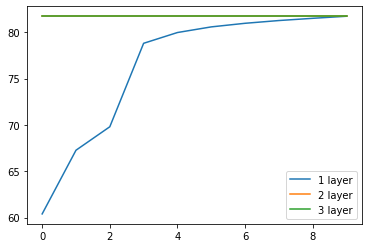

In [59]:
plt.plot(train_1, label = '1 layer')
plt.plot(train_2, label = '2 layer')
plt.plot(train_3, label = '3 layer')
plt.legend()

What is your conclustion on the effect of varying the number of hidden layers on the performance of a neural network trained on the MNIST dataset?

My training accuracies for the 2nd and 3rd layer were approximately the same, so adding another hidden layer will train the model faster, but doesn't necessarily make the model more accurate after a certain number of epochs.

## Part c

Next, we will investigate the effects of varying the activation functions on a neural network. Create 3 networks. The first network has Sigmoid activation (Sigmoid-network). The second network has ReLU activation (ReLU-network). The third network has Tanh activation (Tanh-network). All networks have one hidden layer with size 20.

In [60]:
# Number of training epochs
epochs = 10
# Learning rate
lr = 0.001

# Define the training and testing loss
train_criterion = nn.CrossEntropyLoss()
test_criterion = nn.CrossEntropyLoss(reduction='sum')

Train the Sigmoid-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [61]:
model_s = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')
model_s.activation = torch.nn.Sigmoid()
optimizer = optim.SGD(model_s.parameters(),lr=lr)

train_s = []

for epoch in range(1, epochs + 1):
        # Training
        train(model_s, train_criterion, train_loader, optimizer, epoch)
        train_s.append(test(model_s, test_criterion, train_loader))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301595
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.309707
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.303554
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.304775
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.297797
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.294732
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.285025
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.315665
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.292294
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.287698

Test set: Average loss: 2.2899, Accuracy: 5922/60000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.287932
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.295752
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.292507
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.288934
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.284253
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.282168
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.270616
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.304687
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.279253
T

Test the trained Sigmoid-network on the test data. Print out the accuracy.

In [62]:
test(model_s, test_criterion, test_loader)


Test set: Average loss: 2.1945, Accuracy: 5561/10000 (56%)



55.61

Train the ReLU-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [63]:
model_r = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')
optimizer = optim.SGD(model_r.parameters(),lr=lr)

train_r = []

for epoch in range(1, epochs + 1):
        # Training
        train(model_r, train_criterion, train_loader, optimizer, epoch)
        train_r.append(test(model_r, test_criterion, train_loader))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.281887
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.217042
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.294579
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.148053
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.133491
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.118838
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.027254
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.099699
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.917426
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.996129

Test set: Average loss: 1.8640, Accuracy: 24642/60000 (41%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.756914
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.699863
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.960794
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.649650
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.533370
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.644837
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.634581
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.531609
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.450205


Test the trained ReLU-network on the test data. Print out the accuracy.

In [64]:
test(model_r, test_criterion, test_loader)


Test set: Average loss: 0.6020, Accuracy: 7980/10000 (80%)



79.8

Train the Tanh-network on the MNIST dataset for 10 epochs with learning rate 0.001. After each epoch, record the current training accuracy of the network. 

In [65]:
model_t = mnist_network(num_hidden_layers=1,layer_size=20,activation='tanh')
optimizer = optim.SGD(model_t.parameters(),lr=lr)

train_t = []

for epoch in range(1, epochs + 1):
        # Training
        train(model_t, train_criterion, train_loader, optimizer, epoch)
        train_t.append(test(model_t, test_criterion, train_loader))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.339976
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.083477
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.929702
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.899072
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.778455
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.760510
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.704436
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.745781
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.733356
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.657083

Test set: Average loss: 1.6586, Accuracy: 43411/60000 (72%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.653630
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.630653
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.619556
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.623303
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.578895
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.604777
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.546601
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.602877
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.608471


Test the trained Tanh-network on the test data. Print out the accuracy.

In [66]:
test(model_t, test_criterion, test_loader)


Test set: Average loss: 1.2454, Accuracy: 8842/10000 (88%)



88.42

Plot the training accuracies over the epochs of the networks on the same figure (there should 3 line plots/scatter plots). 

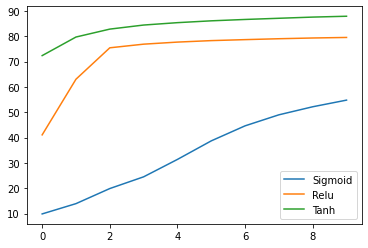

In [67]:
plt.plot(train_s, label = 'Sigmoid')
plt.plot(train_r, label = 'Relu')
plt.plot(train_t, label = 'Tanh')
plt.legend()

What is your conclustion on the effect of varying the activation functions on the performance of a neural network trained on MNIST dataset?

The tanh function appeared to give the highest accuracy, while the relu converged to a lower point and the sigmoid did not seem converge after 10 epochs, so perhaps the sigmoid still has potential as a slow learner.

## Part d

Finally, we will look into the effect of varying the value of the learning rate on the performance of a neural network. Create a network with one hidden layer of size 20 and ReLU activation.

In [68]:
# Number of training epochs
epochs = 10
# Learning rate
lr = 0.1

# Define the training and testing loss
train_criterion = nn.CrossEntropyLoss()
test_criterion = nn.CrossEntropyLoss(reduction='sum')

Train the network on the MNIST dataset for 10 epochs. Set the learning rate to be 0.1. After each epoch, record the current training accuracy of the network. 

In [69]:
model_a = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')
lr = 0.1
optimizer = optim.SGD(model_a.parameters(),lr=lr)

train_a = []

for epoch in range(1, epochs + 1):
        # Training
        train(model_a, train_criterion, train_loader, optimizer, epoch)
        train_a.append(test(model_a, test_criterion, train_loader))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324512
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.312341
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.254524
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.313385
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.211388
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.328997
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.222577
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.268873
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.236029
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.303315

Test set: Average loss: 0.2253, Accuracy: 55840/60000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.139828
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.197228
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.132884
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.228968
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.161075
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.236868
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.160275
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.241555
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.163595


Test the trained network on the test data. Print out the accuracy.

In [70]:
test(model_a, test_criterion, test_loader)


Test set: Average loss: 0.1575, Accuracy: 9559/10000 (96%)



95.59

Train the network on the MNIST dataset for 10 epochs. Set the learning rate to be 0.01. After each epoch, record the current training accuracy of the network. 

In [71]:
model_b = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')
lr = 0.01
optimizer = optim.SGD(model_b.parameters(),lr=lr)

train_b = []

for epoch in range(1, epochs + 1):
        # Training
        train(model_b, train_criterion, train_loader, optimizer, epoch)
        train_b.append(test(model_b, test_criterion, train_loader))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298980
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.415908
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.323044
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.202785
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.837407
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.798797
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.765324
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.963126
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.911553
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.979912

Test set: Average loss: 0.8162, Accuracy: 43478/60000 (72%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.675400
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.627203
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.695437
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.908638
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.662911
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.675273
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.636540
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.893298
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.800239


Test the trained network on the test data. Print out the accuracy.

In [72]:
test(model_b, test_criterion, test_loader)


Test set: Average loss: 0.6322, Accuracy: 7638/10000 (76%)



76.38

Train the network on the MNIST dataset for 10 epochs. Set the learning rate to 0.001. After each epoch, record the current training accuracy of the network. 

In [73]:
model_c = mnist_network(num_hidden_layers=1,layer_size=20,activation='relu')
lr = 0.001
optimizer = optim.SGD(model_c.parameters(),lr=lr)

train_c = []

for epoch in range(1, epochs + 1):
        # Training
        train(model_c, train_criterion, train_loader, optimizer, epoch)
        train_c.append(test(model_c, test_criterion, train_loader))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.353023
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.293145
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.178953
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.157175
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.056528
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.012466
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.778736
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.817686
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.699716
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.477475

Test set: Average loss: 1.5282, Accuracy: 39361/60000 (66%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.623578
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.456735
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.307255
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.257192
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.343965
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.304283
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.936449
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.201425
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.149564


Test the trained network on the test data. Print out the accuracy.

In [74]:
test(model_c, test_criterion, test_loader)


Test set: Average loss: 0.5652, Accuracy: 8212/10000 (82%)



82.12

Plot the training accuracies over the epochs of the scenarios on the same figure (there should 3 line plots/scatter plots). 

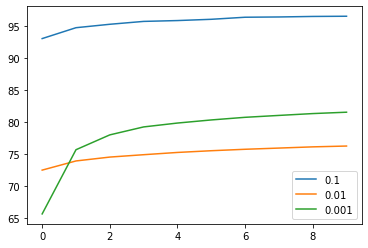

In [75]:
plt.plot(train_a, label = '0.1')
plt.plot(train_b, label = '0.01')
plt.plot(train_c, label = '0.001')
plt.legend()

What is your conclustion on the effect of varying the learning rate on the performance of a neural network?

The learning rate of 0.1 produced the best results, and the general trend that I saw in these three learning rates was that the smaller the learning rate, the longer it took the network to converge to a value of accuracy.

## REMARK for Problem 2

You have observed the effects of varying different hyperparameters on the performance of a neural network **on the MNIST dataset**. However, keep in mind that these trends only apply for **the MNIST dataset** and should not be carried to another problem. There is no single hyperparameter settings that works for all problems. As you do more problems, you will build up your intuitions about the hyperparameters so that you can quickly deploy a good model. For example, people observed that setting the learning rate = 0.001 often works the best, though it is not always the case.

## Problem 3

Experimenting with **k-anonimity, i-diversity, and t-closeness**. 

Consider a dataset, for example, with 3 ordinary attributes and 1 sensitive attribute. Let the 3 ordinary attributes be Age, Sex, and Education and the sensitive attribute be Income, each row in this dataset is of the form:

$$
    [Age, Sex, Education, Income]
$$

A hacker is interested in knowing the sensitive attribute Income. When the dataset is designed so that if complies with either **k-anomity**, **i-diversity**, and/or **t-closeness**, even if he or she somehow figures out the values of the three, the hacker may not retrive the sensitive information accurately. In general, **k-anomity** is weaker than **i-diversity**, which, in turn, is weaker than **t-closeness**.

By definition, **k-anomity** means that there is at least **k** different rows in the table of which ordinary values are a particular combination of Age, Sex, and Education. For example, the hacker knows the information of the person of interest is Age = 31, Sex = Female, and Education = BS. He or she looks into the data table and found that there are 3 rows with that combination:

$$
    [Age=31, Sex=Female, Education=BS, Income=300k]
$$
$$
    [Age=31, Sex=Female, Education=BS, Income=70k]
$$
$$
    [Age=31, Sex=Female, Education=BS, Income=20k]
$$

The hacker cannot tell accurately what the income of the person is because it can be one of the 3 values shown. This particular combination of information has 3-anomity. If every combination corresponds to at least 3 rows, then the dataset has 3-anomity.

a) Let's look at the dataset **"table.csv"**. Let the sensitive attribute be **education** and others be ordinary attributes. Calculate the anomity of the dataset (the value **k**). First, find all the posible combinations of the ordinary attributes that exists in the dataset. After that, determine the anomity for each combination. The anomity of the dataset is the smallest anomity among the combinations.

In [90]:
import pandas as pd
table = pd.read_csv('table.csv')
table.head(5)

,Unnamed: 0,age,education,race,sex
0,0,39,Bachelors,White,Male
1,1,50,Bachelors,White,Male
2,2,38,HS-grad,White,Male
3,3,53,11th,Black,Male
4,4,28,Bachelors,Black,Female


In [107]:
anonimity = min(table.groupby(['age', 'race', 'sex']).count()['education'])
print(f'Anonimity is {anonimity}')

Anonimity is 1


We can improve the **k-anomity** of the dataset by "suppressing" the ordinary attributes. Suppressing means reducing the resolution of the attribute's value. For this problem, let's suppress Age by replacing the exact age with an age range. For example, instead of leaving age = 32, replace it with age = 30-40. Apply this to **"table.csv"** with the ranges {<20, 20-30, 30-50, >50}. Check if the anomity improves. 

In [111]:
def ageRange(age):
    if age < 20:
        return '<20'
    elif age <= 30:
        return '20-30'
    elif age <=50:
        return '30-50'
    else:
        return '>50'

table['age_range'] = table['age'].apply(ageRange)

In [113]:
anonimity = min(table.groupby(['age_range', 'race', 'sex']).count()['education'])
print(f'Anonimity is {anonimity}')

Anonimity is 4


The anonimity improves by 3.

**K-anomity** is nice, however, it fails in many cases. If the rows which share a combination of ordinary attributes have only a few values for the sensitive attribute, then it is not much better than having no anomity at all. For example, consider:

$$
    [Age=31, Sex=Female, Education=BS, Income=300k]
$$
$$
    [Age=31, Sex=Female, Education=BS, Income=20k]
$$
$$
    [Age=31, Sex=Female, Education=BS, Income=20k]
$$
$$
    [Age=31, Sex=Female, Education=BS, Income=20k]
$$

When **k-anomity** fails in the second case, **i-diversity** comes to the rescue. **I-diversity** states that the rows of a particular combination of information must have at least i different values for the sensitive attribute. The above example has 2-diversity, which is not good. 

b) Calculate the **i-diversity** of the dataset **"table.csv"**. Follow similar steps as in part a. 

In [127]:
table = pd.read_csv('table.csv')
table.head(5)

,Unnamed: 0,age,education,race,sex
0,0,39,Bachelors,White,Male
1,1,50,Bachelors,White,Male
2,2,38,HS-grad,White,Male
3,3,53,11th,Black,Male
4,4,28,Bachelors,Black,Female


In [142]:
table.groupby(["age","race", "sex"]).agg({"education":"nunique"}).sort_values('education').head(5)

education
age race               sex              
41  Amer-Indian-Eskimo Female          1
67  Asian-Pac-Islander Male            1
    Amer-Indian-Eskimo Male            1
39  Amer-Indian-Eskimo Male            1
66  Other              Female          1

The i-diversity is 1.

Suppressing an attribute can also improve the **i-diversity** of the dataset. Repeat the suppression as in **part a** and check if the diversity improves. If it does not, consider further suppress age by using the range {<20, 20-50, >50}.

In [143]:
def ageRange_i (age):
    if age < 20:
        return '<20'
    elif age <=50:
        return '20-50'
    else:
        return '>50'

table['age_range'] = table['age'].apply(ageRange_i)
table.groupby(["age_range","race", "sex"]).agg({"education":"nunique"}).sort_values('education').head(5)

education
age_range race               sex              
<20       Amer-Indian-Eskimo Male            3
>50       Other              Female          4
<20       Amer-Indian-Eskimo Female          4
          Asian-Pac-Islander Male            4
          Other              Male            5

The i-diversity is improved from 1 to 3.

**T-closeness** is even better than **i-diversity**. **T-closeness** requires that for every combination of information, the distribution of the sensitive attribute's value among the corresponding rows must be close to the overall distribution of the sensitive attribute's value for the whole dataset. Distance between distribution is calculated using the Earth Mover Distance (EMD). The dataset has **t-closeness** if no distance exceeds **t**. 

c) Calculate the overall distribution of **education**. Find the **t-closeness** of the dataset (largest distance between any combination's distribution of marital-status and the overall distribution).

You can use **scipy.stats.wasserstein_distance** to calculate the EMD.

In [144]:
from scipy.stats import wasserstein_distance

table = pd.read_csv('table.csv')

In [148]:
table['race'] = pd.factorize(table['race'])[0]
table['sex'] = pd.factorize(table['sex'])[0]
table['education'] = pd.factorize(table['education'])[0]

ages = np.unique(table['age'])
races = np.unique(table['race'])
sexes = np.unique(table['sex'])

In [149]:
education = (table['education'])
distances = []

for age in range(len(ages)):
    for race in range(len(races)):
        for sex in range(len(sexes)):
            temp = table[(table['age']==age) & (table['race']==race) & (table['sex']==sex)]
            if temp.empty:
                distances.append(wasserstein_distance([0], education)) 
            else:
                use = temp.iloc[:, 2]
                distances.append(wasserstein_distance(use, education))

In [155]:
closeness = max(distances) - min(distances)
closeness

11.44312068583628